In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [47]:
import numpy as np

from utils.dataset import create_dataloaders, load_img
from torchvision.transforms import Normalize
import matplotlib.pyplot as plt

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = Normalize(mean=mean, std=std)
unormalize = Normalize(mean=-mean/std, std=1/std)
train_dataloader, val_dataloader = create_dataloaders(path="../data", transforms=normalize)

In [53]:
class VGGFCN_Base(nn.Module):
    def __init__(self):
        super(VGGFCN_Base, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(4096, 1000, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(1000, 1, kernel_size=1)
        )
        # Process to transfer weights from linear layers
        # into convolutionar layers
        self._initialize_weights()
        
    def _initialize_weights(self):
        self.classifier[0].weight.data = (
            self.vgg16.classifier[0].weight.data.view(
                self.classifier[0].weight.size()
            )
        )
        self.classifier[3].weight.data = (
            self.vgg16.classifier[3].weight.data.view(
                self.classifier[3].weight.size()
            )
        )
        self.classifier[6].weight.data = (
            self.vgg16.classifier[6].weight.data.view(
                self.classifier[6].weight.size()
            )
        )
        
class VGGFCN32(VGGFCN_Base):
    def forward(self, x):
        bs, _, input_height, input_width = x.size()
        x = self.vgg16.features(x)
        x = self.classifier(x)
        x = F.interpolate(x, size=(input_height, input_width),
                         mode='bilinear', align_corners=True)
        return x

In [54]:
model = VGGFCN32()

In [55]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 3e-4, weight_decay = 0)
#loss = nn.CrossEntropyLoss()
loss = nn.BCEWithLogitsLoss()

In [56]:
def train():
    loss_mean = 0
    i = 0
    model.train()
    for x_img, y_mask in train_dataloader:
        optimizer.zero_grad()
        
        y_mask_pred = model(x_img)
        loss_item = loss(y_mask_pred, y_mask.view(x_img.shape[0], 1, 224, 224))
        
        loss_mean += loss_item.item()
        i += 1
        
        loss_item.backward()
        optimizer.step()
    print("train step error: %.3f" % (loss_mean/i))

In [57]:
def val():
    model.eval()
    loss_mean = 0
    i = 0
    for x_img, y_mask in val_dataloader:
        with torch.no_grad():
            y_mask_pred = model(x_img)
        loss_item = loss(y_mask_pred, y_mask.view(x_img.shape[0], 1, 224, 224))
        loss_mean += loss_item.item()
        i += 1
        
    print("val step error: %.3f" % (loss_mean/i))

In [ ]:
for i in range(50):
    print("Step %i" %(i))
    train()
    val()

Step 0
train step error: 0.405
val step error: 0.208
Step 1
train step error: 0.227
val step error: 0.213
Step 2
train step error: 0.180
val step error: 0.158
Step 3
train step error: 0.139
val step error: 0.132
Step 4
train step error: 0.118
val step error: 0.122
Step 5
train step error: 0.100
val step error: 0.118
Step 6
train step error: 0.096
val step error: 0.108
Step 7
train step error: 0.092
val step error: 0.130
Step 8
train step error: 0.091
val step error: 0.121
Step 9
train step error: 0.082
val step error: 0.104
Step 10
train step error: 0.078
val step error: 0.104
Step 11
train step error: 0.073
val step error: 0.106
Step 12
train step error: 0.069
val step error: 0.106
Step 13
train step error: 0.066
val step error: 0.100
Step 14
train step error: 0.063
val step error: 0.108
Step 15
train step error: 0.063
val step error: 0.110
Step 16
train step error: 0.066
val step error: 0.116
Step 17
train step error: 0.064
val step error: 0.101
Step 18
train step error: 0.059
val st

In [64]:
softmax = nn.Softmax(dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


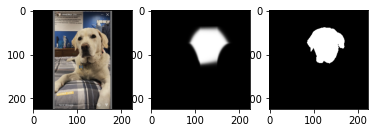

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


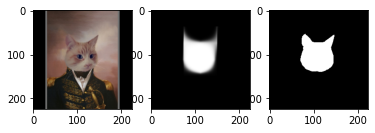

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


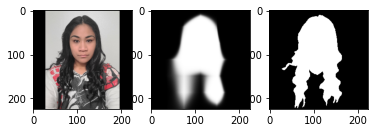

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


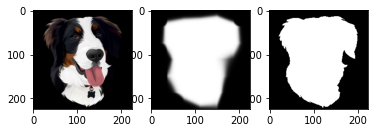

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


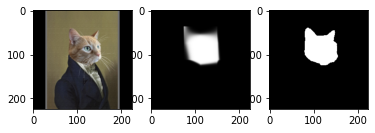

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


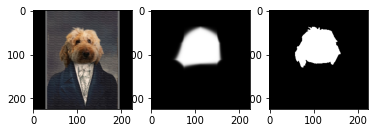

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


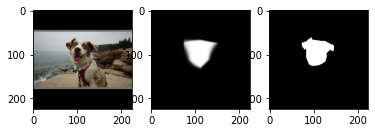

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


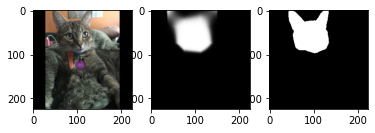

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


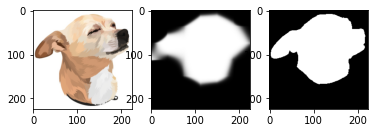

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


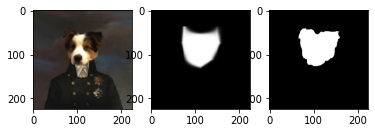

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


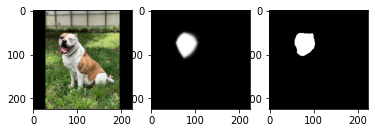

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


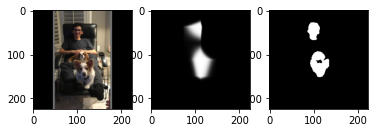

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


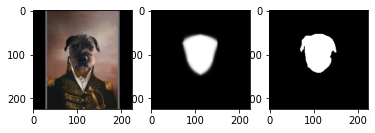

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


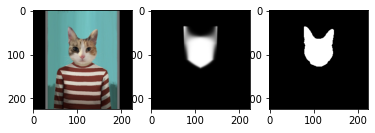

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


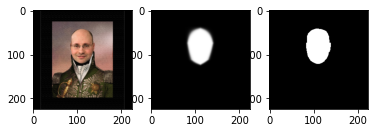

In [60]:
model.eval()
for batch_img, batch_mask in train_dataloader:
    pred_mask = model(batch_img).detach()
    pred_mask = pred_mask.sigmoid()
    for idx in range(batch_img.shape[0]):
        plt.subplot(1,3,1)
        plt.imshow(np.transpose(unormalize(batch_img[idx]), (1, 2, 0)))
        
        plt.subplot(1,3,2)
        plt.imshow(pred_mask[idx].squeeze(), cmap="gray")
        
        plt.subplot(1,3,3)
        plt.imshow(batch_mask[idx].view(224, 224), cmap="gray")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


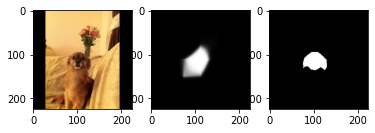

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


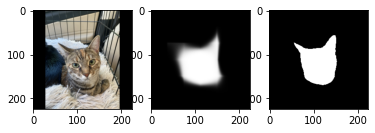

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


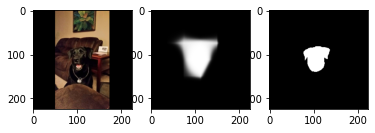

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


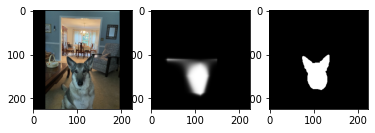

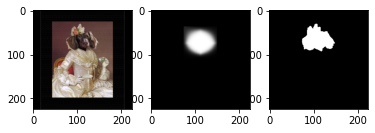

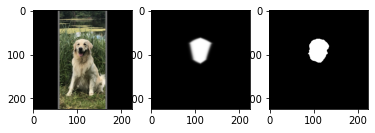

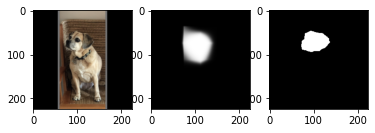

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


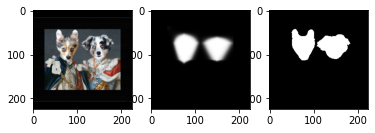

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


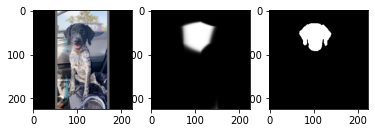

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


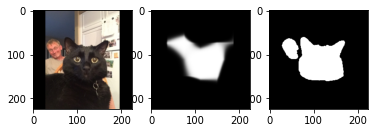

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


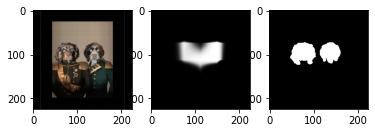

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


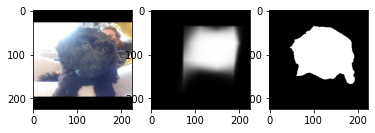

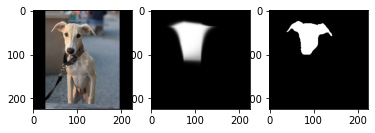

In [61]:
model.eval()
for batch_img, batch_mask in val_dataloader:
    pred_mask = model(batch_img).detach()
    pred_mask = pred_mask.sigmoid()
    for idx in range(batch_img.shape[0]):
        plt.subplot(1,3,1)
        plt.imshow(np.transpose(unormalize(batch_img[idx]), (1, 2, 0)))
        
        plt.subplot(1,3,2)
        plt.imshow(pred_mask[idx].squeeze(), cmap="gray")
        
        plt.subplot(1,3,3)
        plt.imshow(batch_mask[idx].view(224, 224), cmap="gray")
    plt.show()

In [62]:
!curl https://www.cdc.gov/importation/images/cat.jpg -o test_imgs/dog.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14913  100 14913    0     0  58027      0 --:--:-- --:--:-- --:--:-- 58027


In [63]:
import cv2
import numpy as np

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

img = cv2.imread("test_imgs/image.jpeg")
img = letterbox(img)[0]
cv2.imwrite("image.jpg", img)

True

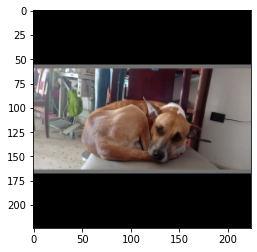

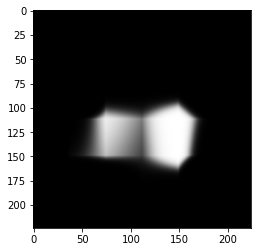

In [64]:
img = load_img("image.jpg", img_size=224)
model.eval()
mask = model(normalize(img).unsqueeze(0)).detach()
mask = mask.sigmoid().squeeze()

plt.imshow(np.transpose(img, (1,2,0)))
plt.show()

plt.imshow(mask, cmap="gray")
plt.show()

In [73]:
trace = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
trace.save("models/torch.jit.pt")